In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Functional, Model, load_model
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from PIL import Image
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from os import listdir
from keras.applications import imagenet_utils
import cv2
import warnings
from keras.preprocessing import image
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [66]:
def crop_img(path_to_image):
    img = cv2.imread(path_to_image)
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img = cv2.resize(img, (512, 512))
    img = img[43:362, 60:480]
    img = cv2.resize(img, (512, 512))
    out = []
    for i in range(8):
        temp = []
        for j in range(8):
            temp.append(img[i*64:(i+1)*64,j*64:(j+1)*64])
        out.append(temp)
    return out

In [64]:
img = cv2.imread('../../data/chessBot/1.png')
# change bgr to rgb
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# rotate image 90 degree anti-clockwise
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
# resize image
img = cv2.resize(img, (512, 512))
img = cv2.rectangle(img, (60, 43), (479, 361), (255,0,255),1)
# crop this rectangle
img = img[43:362, 60:480]
# crop image from center
# img = img[100:300, 100:300]

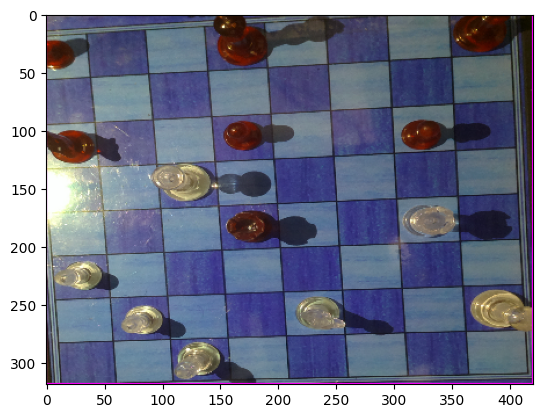

In [65]:
plt.imshow(img)

In [157]:
imgs = crop_img('../../data/chessBot/8.png')

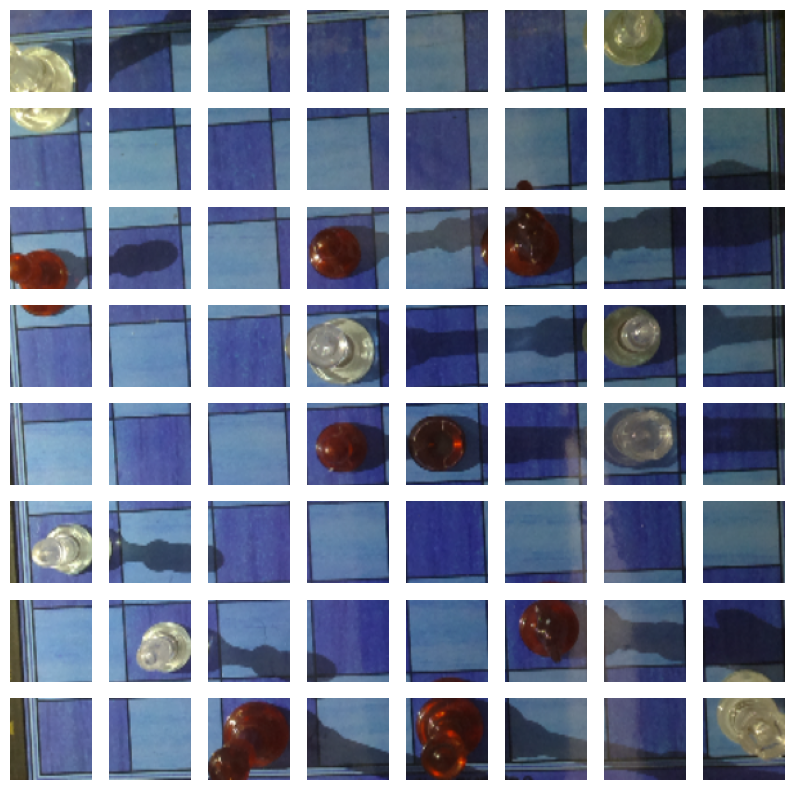

In [158]:
# plot them in grid
fig, axs = plt.subplots(8, 8, figsize=(10, 10))
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(imgs[i][j])
        axs[i,j].axis('off')
plt.show()

In [ ]:
# 1, 2, 3, 4, 5, 6
# 11, 12
# 13, 14

In [111]:
e = 0
w = 1
b = 2
actual = ['empty', 'white', 'black']

In [159]:
train_labels = [
	[
	[b, e, e, b, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, b, e],
	[e, e, w, e, e, e, e, e],
	[e, e, e, b, e, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, w, e, e, w],
	[e, e, w, e, e, e, e, e]
	],
	[
	[b, e, e, w, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, b, e],
	[e, e, e, e, e, e, e, e],
	[e, e, e, e, e, e, w, e],
	[w, e, b, e, e, b, e, e],
	[e, w, e, e, w, e, e, w],
	[e, e, w, e, e, e, e, e]
	],
	[
	[b, e, e, w, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[e, e, w, b, e, e, w, b],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, e, e, w],
	[e, e, w, e, e, e, e, e]
	],
	[
	[b, e, e, e, e, w, e, b],
	[e, e, e, e, e, e, e, e],
	[b, w, e, b, e, e, e, b],
	[e, e, e, e, e, e, w, e],
	[e, e, e, b, e, e, w, b],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, w, e, e, e],
	[e, e, e, e, e, e, e, e]
	],
	[
	[e, e, b, e, e, w, e, e],
	[e, e, e, e, e, e, e, e],
	[b, b, e, b, e, e, e, b],
	[e, e, e, e, e, e, w, e],
	[e, w, e, e, w, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, b, e, e],
	[e, e, e, e, b, e, e, e]
	],
	[
	[w, e, b, e, e, w, e, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, w, e, b],
	[e, b, e, e, e, e, w, e],
	[e, e, e, b, e, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, b, e, e],
	[e, e, e, e, b, e, e, w]
	]
]

val_labels = [
	[
	[e, e, w, e, e, e, w, e],
	[e, e, b, e, e, e, e, w],
	[b, e, e, b, e, b, e, e],
	[e, e, e, e, e, e, w, e],
	[e, e, e, b, e, b, e, e],
	[w, e, e, w, e, e, e, e],
	[e, e, e, e, e, b, e, e],
	[w, e, b, e, e, e, e, w]
	],
	[
	[w, e, w, e, b, e, w, e],
	[e, e, e, e, e, e, e, w],
	[b, e, e, b, e, b, e, e],
	[e, e, b, e, e, e, w, e],
	[e, e, e, b, e, e, e, e],
	[w, e, e, w, e, e, e, e],
	[e, e, e, e, e ,b, e, e],
	[e, e, b, e, e, e, e, w]
	]
]

test_labels = [
	[
	[w, e, w, e, b, e, w, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, b, e, e],
	[e, e, b, e, b, e, e, e],
	[e, b, e, b, e, e, e, e],
	[w, e, e, w, e, e, e, w],
	[e, e, e, e, e, e, e, e],
	[e, e, e, w, e, e, e, w]
	],
	[
	[w, e, w, e, b, e, w, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, e, w],
	[e, e, e, e, b, e, e, e],
	[e, e, e, b, e, e, e, e],
	[w, e, e, w, e, e, b, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, w, e, b, e, w]
	]
]
more_labels = [
	[
	[w, e, b, e, b, e, w, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, e, e], 
	[e, b, e, e, e, e, w, e],
	[e, e, e, b, e, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, b, e, e],
	[w, e, e, e, b, e, e, w]
	],
	[
	[w, e, e, e, e, e, w, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, b, e, e],
	[e, e, e, w, e, e, w, e],
	[e, e, e, b, b, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, b, e, e],
	[e, e, b, e, b, e, e, w]
	]
]

In [112]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(len(train_labels)):
    imgs = crop_img(f'../../data/chessBot/{i+1}.png')
    for j in range(8):
        for k in range(8):
            l = train_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/train/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/train/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/train/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [113]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(2):
    imgs = crop_img(f'../../data/chessBot/{11+i}.png')
    for j in range(8):
        for k in range(8):
            l = val_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/val/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/val/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/val/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [114]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(2):
    imgs = crop_img(f'../../data/chessBot/{13+i}.png')
    for j in range(8):
        for k in range(8):
            l = test_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/test/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/test/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/test/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [160]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(2):
    imgs = crop_img(f'../../data/chessBot/{7+i}.png')
    for j in range(8):
        for k in range(8):
            l = more_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/more/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/more/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/more/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [4]:
train_path='../../data/chessBot/train/'
valid_path='../../data/chessBot/val/'
test_path='../../data/chessBot/test/'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 384 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


In [135]:
# names of classes
train_batches.class_indices

{'black': 0, 'empty': 1, 'white': 2}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

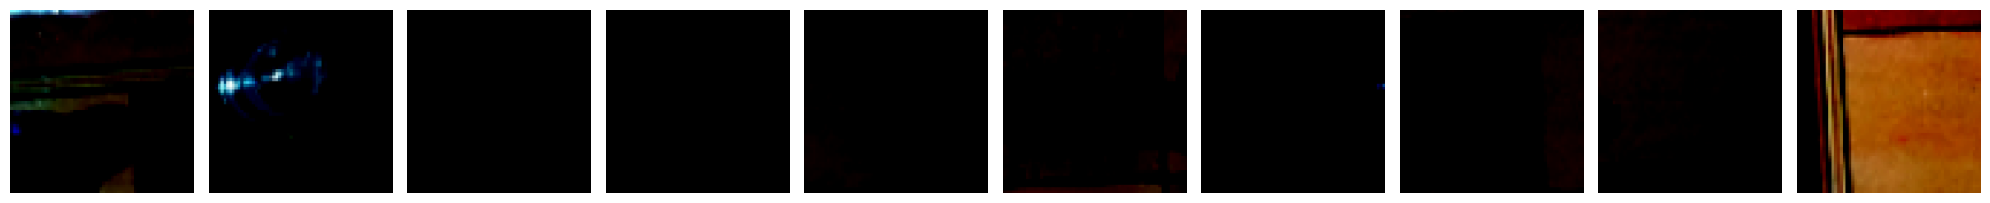

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [141]:
imgs, labels = next(train_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)

In [115]:
mobile=keras.applications.mobilenet.MobileNet()

2023-04-16 17:24:11.865736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaryan/py/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-16 17:24:11.865809: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 17:24:11.865857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aaryan): /proc/driver/nvidia/version does not exist
2023-04-16 17:24:11.907553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

17225924/17225924 [==============================] - 2s 0us/step


In [142]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [143]:
x = mobile.layers[-6].output
x = tf.keras.layers.Reshape((1, 1, 1024))(x)
output = Dense(units=3, activation='softmax')(x)

In [145]:
model = Model(inputs=mobile.input, outputs=output)

In [146]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [147]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [148]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(x=train_batches, validation_data=valid_batches, epochs = 15, verbose = 2)

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model('model.h5') # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('saved_model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [3]:
model = load_model('model.h5')

2023-04-16 20:10:13.432306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaryan/py/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-16 20:10:13.432401: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 20:10:13.432502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aaryan): /proc/driver/nvidia/version does not exist
2023-04-16 20:10:13.445304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

In [6]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [7]:
# {'black': 0, 'empty': 1, 'white': 2}
predictions.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Prediction: B


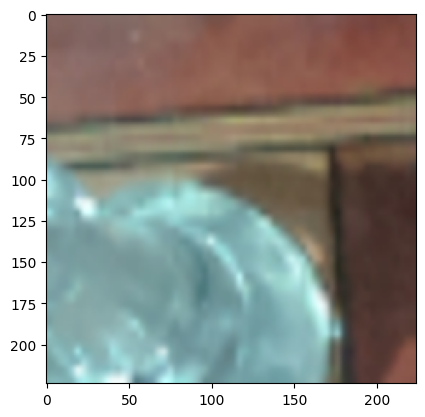

In [24]:
img = Image.open('../../data/chessBot/more/white/8.png')
# pre process using mobilenet preprocess_input
img = img.resize((224, 224))
plt.imshow(img)
img = tf.keras.applications.mobilenet.preprocess_input(np.array(img, dtype=np.float32))
img = np.expand_dims(img, axis=0)
# Plot the image
arr = ['B', 'E', 'W']
print(f"Prediction: {arr[model.predict(img, verbose = 0).argmax(axis=1)[0]]}")

In [ ]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)